In [10]:
# stanのバージョンが v3.3 になり import pystan ではなくではなく import stan とライブラリ名がが
# 変わると当時に、build 時に以下のエラーがでるようになった。
# 対策としてnest_asyncio というライブラリを使う必要があるため、最初の一回のみライブラリをインストールしておくしておく
# 一回 install すれば、あとはこのコマンドは不要なので、先頭にに#をつけてコメントにしておいてください。
## RuntimeError: asyncio.run() cannot be called from a running event loop

!pip install nest_asyncio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

input_dir = "/content/drive/MyDrive/input/"
output_dir = "/content/drive/MyDrive/output/"

# pystan と、パラメータの事後分布の推定結果を可視化するためのライブラリとして arviz を利用する。
import stan
import arviz
import nest_asyncio # stanのバージョンアップ対策
nest_asyncio.apply() # stanのバージョンアップ対策


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


階層モデルは、グループに由来する差異（グループ差）や個人に由来する差異（個人差）を扱うため一つの手法です。

ここでは線形回帰上で「グループ差を表すパラメータ類似しており、特定の分布から生成される」という過程をおいた階層モデルの構築を体験してみます。

## (1) グループ差を考えない通常の線形回帰

データを変更しますが、note6-1の単回帰のコードです。このノートではこれを最終的に階層モデルに拡張します。なお、デザイン行列で階層モデルを作ると理解しにくいため、単回帰のパラメータをを b0 , b1 に独立して定義するバージョンをもとに始めます。

In [12]:
!cat /content/drive/MyDrive/input/data-salary-2.txt


X,Y,KID
7,457,1
10,482,1
16,518,1
25,535,1
5,427,1
25,603,1
26,610,1
18,484,1
17,508,1
1,380,1
5,453,1
4,391,1
19,559,1
10,453,1
21,517,1
12,553,2
17,653,2
22,763,2
9,538,2
18,708,2
21,740,2
6,437,2
15,646,2
4,422,2
7,444,2
10,504,2
2,376,2
15,522,3
27,623,3
14,515,3
18,542,3
20,529,3
18,540,3
11,411,3
26,666,3
22,641,3
25,592,3
28,722,4
24,726,4
22,728,4


(40, 3)


,X,Y,KID
0,7,457,1
1,10,482,1
2,16,518,1
3,25,535,1
4,5,427,1


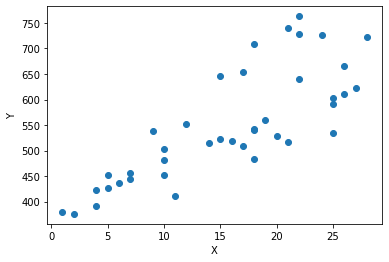

In [13]:
data = pd.read_csv(input_dir+'data-salary-2.txt') 

# len()でデータフレームの行数を取得
sample_size = len(data)

plt.scatter(data.X, data.Y)
plt.xlabel('X')
plt.ylabel('Y')

print(data.shape) # 次元を確認
data.head() # データの先頭を確認確認 data.tail() で後ろからも確認できる

{1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 2: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26], 3: [27, 28, 29, 30, 31, 32, 33, 34, 35, 36], 4: [37, 38, 39]}


Text(0, 0.5, 'Y')

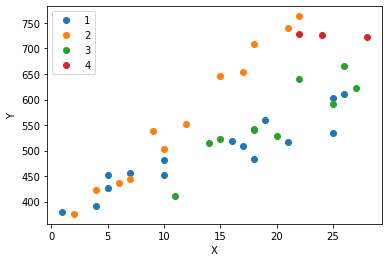

In [14]:
## グループ情報を可視化する

groups = data.groupby('KID') # groupby は DataFrame 型に実装されていて、変数 groups は GroupByオブジェクトになる。詳細は https://deepage.net/features/pandas-groupby.html あたりを参考にしてください。
print (groups.groups) # グループIDの値で、で、index別にグループ分けされていることが確認できます。

for name, group in groups: # これを使うと、特定の項目でグループ分けしたグラフが簡単に表示できます
    plt.plot(group.X, group.Y, marker='o', linestyle='', label=name)
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')


In [15]:
x = data['X'].values # 説明変数の抽出
y = data['Y'].values # 目的変数の抽出

# Stan に入力するデータを作成
stan_data = {
    'N': data.shape[0],
    'x': x, 
    'y': y
}

#stan_data

説明変数がが1つの単回帰モデルを使います。N個のデータがあり、目的変数を $y$ 説明変数を $x$ で残差は \epsilon とします。<BR>
$ 𝑦_i = 𝑏_0 + 𝑏_1 𝑥_i, (i = 1,2, ..., N)$ <BR>
$ \epsilon_i \sim N(0, 𝜎)$

これは確率モデルと同等です。<BR>
$ 𝑦_i \sim 𝑁(𝑏_0 + 𝑏_1 𝑥_i, 𝜎), i = 1,2, ..., N $


In [16]:
stan_code = """
data {
  int N; // データ数
  vector[N] x; // real x[N]; と書いても同じ。
  vector[N] y; // real y[N]; と書いても同じ。
}

parameters {
  real b0;       // 切片
  real b1;       // 傾き 単回帰なので単独の変数にしているが、重回帰ではここを配列にして使うこともできる。
  real<lower=0> sigma; // 標準偏差 <lower=0>は、0以上の値しか取らないという指定
}

model {
  for (i in 1:N) {
    y[i] ~ normal (b0 + b1 * x[i], sigma); // 線形単回帰モデル, b0とb1の事前分布は定義していないので-∞から+∞の一様分布
  }
}
"""

In [8]:
model = stan.build(stan_code, data=stan_data, random_seed=1)
# MCMCの実行
fit = model.sample(
    num_warmup = 1000, # バーンイン期間
    num_chains = 4, #チェーン数
    num_samples= 2000, # 乱数生成の繰り返し回数
    num_thin = 1, #間引き数
)

Building...



Building: 31.0s, done.Messages from stanc:
Sampling:   0%
Sampling:   8% (900/12000)
Sampling:  32% (3900/12000)
Sampling:  58% (6900/12000)
Sampling:  82% (9900/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 2.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,376.102,25.476,330.711,426.066,0.500,0.357,2683.0,2698.0,1.0
b1,11.054,1.468,8.245,13.800,0.028,0.020,2753.0,2584.0,1.0
sigma,68.599,8.123,54.047,83.894,0.149,0.106,3104.0,3374.0,1.0


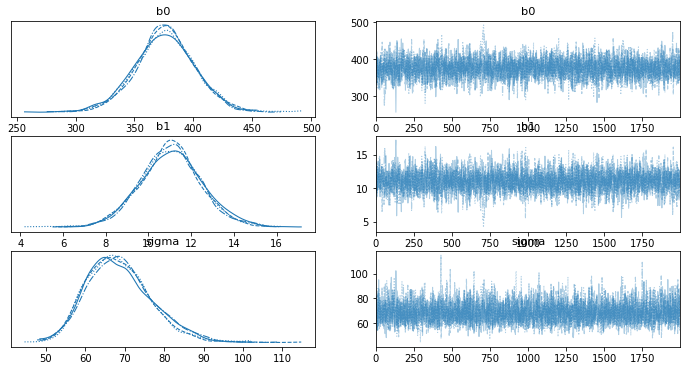

In [9]:
# MCMCの経過を簡易表示, muとsigmaのiter変化が見られる
arviz.plot_trace(fit)

#  Gelman-Rubin 統計量 (r_hat)、Highest density interval (HDI) などの簡易表示
summary = arviz.summary(fit)
summary

In [17]:
result = fit.to_frame()

# 先頭を表示
result.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,b0,b1,sigma
draws,,,,,,,,,,
0,-183.841531,0.960838,0.279606,3.0,7.0,0.0,185.025574,346.692312,12.712133,59.850740
1,-183.472702,0.985621,0.287173,3.0,15.0,0.0,186.304746,389.236281,9.632055,65.919004
2,-183.811184,0.990135,0.281759,3.0,7.0,0.0,184.863124,410.550705,9.098336,71.700873
3,-183.296657,0.897449,0.376113,4.0,15.0,0.0,183.876931,361.746422,11.874183,58.557796
4,-183.810670,0.989382,0.279606,4.0,15.0,0.0,184.165072,408.691407,8.914822,69.187009


In [18]:
b0, b1, sigma = np.mean(result['b0']), np.mean(result['b1']), np.mean(result['sigma']) # sigma はいつもの方法で取り出せます

Text(0, 0.5, 'Salary (yen)')

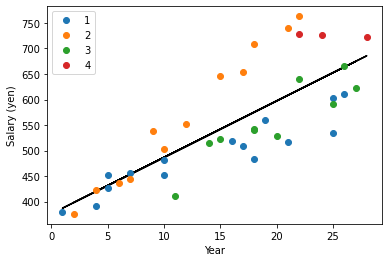

In [19]:
plt.plot(x, b0 + b1 * x, color='black')
for name, group in groups: # これを使うと、特定の項目でグループ分けしたグラフが簡単に表示できます
    plt.plot(group.X, group.Y, marker='o', linestyle='', label=name)
plt.legend()
plt.xlabel('Year') # 年齢、ただし実際の年齢から23を引いている。
plt.ylabel('Salary (yen)') # 年収


所属年数が1年たつごとに、給与がが11万あがるという結果となった。本当にこれでよいのか？
グループ（会社）によっての違いがあるのでは？ID=4の会社に至ってはデータと逆向きになっている。
またパラメータ sigma が 68.2 とかなり大きいように感じる。

回帰分析は、サンプルが独立していることを過程しているが、この場合は、データに階層性があり（階層データ）、サンプルが独立していません。本来、回帰係数は、グループによる性質と個人の性質が混在していそうなのに、すべて同一に扱っているのが問題です。

## (2) グループごとの線形回帰（階層はなし）

データが4グループからなるため、次は、グループごとに線形回帰を行ってみます。<BR>
そのためには、各サンプル（個人）がどのグループ（会社）に入っているの情報を使います。

データを会社別に別にグループに分けて、グループ数をGとおき、G=4、4種類の回帰モデルを作ってみます。<BR>

$ 𝑦_{ij} \sim 𝑁(𝑏_{0j} + 𝑏_{1j}𝑥_i, 𝜎)$ <BR>$(i = 1,2, ..., N, j = 1, 2, ... G)$

ここで、添字のj はグループ(会社)を表し、iはサンプル（個人）を表しています。<BR>
上の式と下のコードで、b0 や b1 がグループ別になっていることに注意してください。

In [20]:
group = data['KID'].values # グループIDの抽出
print (group) # そのサンプルがどのグループかをIDで分けている。
print (list(set(group))) # 何種類のグループがあるかを確認するため、set で重複を削除した集合を set 型で作成し、list 型に変更し、print してみる。

# Stan に入力するデータを作成
stan_data2 = {
    'N': data.shape[0],
    'G': len(list(set(group))),
    'x': x, 
    'y': y,
    'group': group
}

#stan_data2

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3
 4 4 4]
[1, 2, 3, 4]


In [21]:
stan_code2 = """
data {
  int N; // データ数
  int G; // 追加：グループ数
  real x[N];
  real y[N];
  int<lower=1, upper=G> group[N]; // 追加：データごとの group ID情報
}

parameters {
  real b0_g[G];       // 変更：切片 b9 でもよいが区別するためするため b0_g[G] になり、グループごとの切片になった。
  real b1_g[G];       // 変更：同様に、傾き b1 から b1_g[G] になり、グループごとの傾きになった。
  real<lower=0> sigma; // 標準偏差 <lower=0>は、0以上の値しか取らないという指定。ここは変更なし。ノイズの大きさは共通とする。
}

model {
  for (i in 1:N) {
    y[i] ~ normal (b0_g[group[i]] + b1_g[group[i]] * x[i], sigma); // 変更：グループIDごとに b0 と b1 を分けて線形単回帰する。group IDは、純粋なpythonと違い1から始まる数を前提にしていることに注意が必要
  }
}
"""

In [22]:
model2 = stan.build(stan_code2, data=stan_data2, random_seed=1)
# MCMCの実行
fit2 = model2.sample(
    num_warmup = 1000, # バーンイン期間
    num_chains = 4, #チェーン数
    num_samples= 2000, # 乱数生成の繰り返し回数
    num_thin = 1, #間引き数
)

Building...



Building: 41.0s, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   2% (201/12000)
Sampling:   2% (300/12000)
Sampling:   8% (900/12000)
Sampling:  32% (3800/12000)
Sampling:  57% (6800/12000)
Sampling:  82% (9800/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 6.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.64 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adju

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0_g[0],387.167,14.048,360.867,413.838,0.183,0.129,5989.0,4797.0,1.0
b0_g[1],328.877,17.151,297.763,362.701,0.224,0.159,5873.0,4921.0,1.0
b0_g[2],314.118,34.581,250.177,379.480,0.469,0.332,5442.0,4909.0,1.0
b0_g[3],750.458,158.123,457.471,1052.941,2.211,1.563,5206.0,4156.0,1.0
b1_g[0],7.514,0.864,5.885,9.144,0.011,0.008,6066.0,5336.0,1.0
b1_g[1],19.838,1.257,17.414,22.153,0.016,0.012,5970.0,4848.0,1.0
b1_g[2],12.446,1.711,9.274,15.669,0.023,0.016,5578.0,4589.0,1.0
b1_g[3],-1.021,6.382,-13.129,10.904,0.089,0.078,5223.0,4019.0,1.0
sigma,27.418,3.718,20.850,34.116,0.052,0.037,5492.0,4820.0,1.0


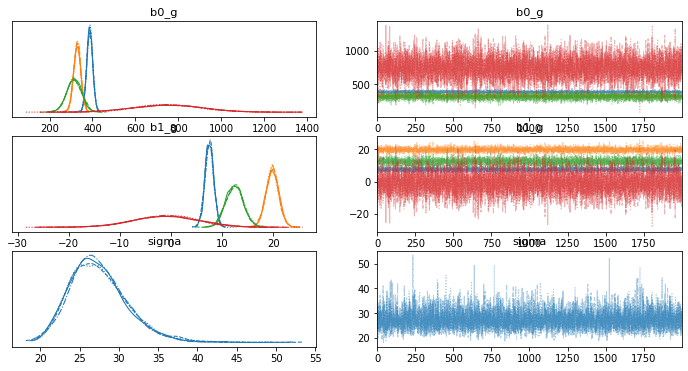

In [23]:
# MCMCの経過を簡易表示, muとsigmaのiter変化が見られる
arviz.plot_trace(fit2)

#  Gelman-Rubin 統計量 (r_hat)、Highest density interval (HDI) などの簡易表示
summary2 = arviz.summary(fit2)
summary2

In [24]:
result2 = fit2.to_frame()

# 先頭を表示
result2.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,b0_g.1,b0_g.2,b0_g.3,b0_g.4,b1_g.1,b1_g.2,b1_g.3,b1_g.4,sigma
draws,,,,,,,,,,,,,,,,
0,-147.402931,0.853935,0.086298,5.0,63.0,0.0,155.289017,389.684882,347.431787,354.730278,817.203008,8.114903,18.314695,10.820658,-3.248169,28.475628
1,-148.047576,0.994612,0.063110,6.0,63.0,0.0,152.540960,376.033963,325.818289,331.510300,859.557767,7.076574,19.611012,11.787264,-5.431235,30.067283
2,-147.703000,0.870226,0.075425,6.0,63.0,0.0,152.867631,393.572526,328.655822,277.030011,608.639449,6.901378,19.317549,13.447007,4.140155,29.128028
3,-148.511589,0.999305,0.078276,6.0,63.0,0.0,151.364917,352.720358,335.194433,335.342934,877.982043,8.915332,19.014814,11.796845,-6.319633,26.571136
4,-145.071636,0.989313,0.086298,5.0,47.0,0.0,148.798701,389.358889,310.975678,303.482064,838.390616,7.664033,21.003529,13.353249,-4.992063,24.994876


In [25]:
b0_g1, b1_g1 = np.mean(result2['b0_g.1']), np.mean(result2['b1_g.1'])
print ("1", b0_g1, b1_g1)

b0_g2, b1_g2 = np.mean(result2['b0_g.2']), np.mean(result2['b1_g.2'])
print ("2", b0_g2, b1_g2)

b0_g3, b1_g3 = np.mean(result2['b0_g.3']), np.mean(result2['b1_g.3'])
print ("3", b0_g3, b1_g3)

b0_g4, b1_g4 = np.mean(result2['b0_g.4']), np.mean(result2['b1_g.4'])
print ("4", b0_g4, b1_g4)

1 387.1674608727912 7.514461978306468
2 328.8773880988196 19.838013812552592
3 314.1183750216115 12.445586722970896
4 750.4575216944334 -1.0206742443050374


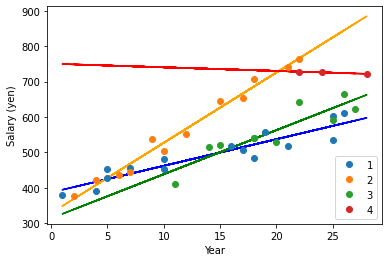

In [26]:
plt.plot(x, b0_g1 + b1_g1 * x, color='blue')
plt.plot(x, b0_g2 + b1_g2 * x, color='orange')
plt.plot(x, b0_g3 + b1_g3 * x, color='green')
plt.plot(x, b0_g4 + b1_g4 * x, color='red')
plt.xlabel('Year') # 年齢、ただし実際の年齢から23を引いている。
plt.ylabel('Salary (yen)') # 年収

for name, group in groups: # これを使うと、特定の項目でグループ分けしたグラフが簡単に表示できます
    plt.plot(group.X, group.Y, marker='o', linestyle='', label=name)
plt.legend()

前の結果では、在職年数が1年たつごとに、給与がが11万あがるという結果となっていましたが、会社によってその傾向が大きく違うことがわかります。<BR>

ただし、上記の結果は、グループごとに直瀬の切片と傾きを得ているが、各グループ（会社）の b0 と b1 についての仮定がないため、グループによる差を扱うことはできません。そのため、このデータに含まれていない、グループ情報がない会社について、切片や傾きがいくらになりそうか、という予測もできません。

また、会社ごとにデータをわけたときに、データが十分にないグループの b0 や b1 はうまく推定できません。例えば、グループ4については予測があやしい。

## (3) 階層モデル v1

では、事前分布のパラメータ間にさらに分布を仮定する「階層モデル」を線形回帰を作ってみます。
いろいろな拡張方法が考えられますが、大まかに分けると以下のの3通りが考えられます。どれを選ぶかにより解析者の意図が入ることに注意してください。

1. 切片だけにグループ差を考慮する
2. 回帰係数だけにグループ差を考慮する
3. 切片と回帰係数の両方にグループ差を考慮する

ここでは、3. を採用し、基本的には以下の構造を過程してみます。

$ 𝑦_{i} \sim 𝑁(𝑏_{0j[i]} + 𝑏_{1j[i]}𝑥_i, 𝜎)$<BR>
$ 𝑏_{0j} \sim 𝑁(\mu_0, 𝜎_0)$<BR>
$ 𝑏_{1j} \sim 𝑁(\mu_1, 𝜎_1)$<BR>
$(i = 1,2, ..., N, j = 1, 2, ... G)$

そこで、各データの $b_{0j}$ ($j = 1, ..., 4$) を $𝑏_{0, \rm{group}}$ と書き、「すべてのデータで共通の全体平均」$𝑏_0$ と「グループ差」$b_{0, \rm{diff}}$に分けて考える。さらに「グループ差」を表すパラメータは、平均0、標準偏差 $\sigma_{b0}$ の正規分布から生成されると考える。$b_{1j}$ についても同様に $𝑏_{1,\rm{group}}$ と書き、$𝑏_1$ と $b_{1, \rm{diff}}$ に分け、$b_{1, \rm{diff}}$は、平均0、標準偏差 $\sigma_{b1}$ の正規分布から生成されると考える。

$ 𝑦_{i} \sim 𝑁(𝑏_{0, \rm{group}} + 𝑏_{1, \rm{group}}𝑥_i, 𝜎)$<BR>
$ 𝑏_{0, \rm{group}} = b_0 + b_{0, \rm{diff}}$<BR>
$ 𝑏_{1, \rm{group}} = b_1 + b_{1, \rm{diff}}$<BR>
$ 𝑏_{0, \rm{diff}} \sim 𝑁(0, \sigma_{b0})$<BR>
$ 𝑏_{1, \rm{diff}} \sim 𝑁(0, \sigma_{b1})$<BR>
$(i = 1,2, ..., N, group = 1, 2, ... G)$

このような仮定を入れて予測すると、例えば「新卒の基本年収」のグループ差のばらつきは、$\sigma_{b0}$ ぐらいだということができる。また、数点しかデータがないグループでも、そのデータを生かして、そのグループの b0 と b1 および全体の $\sigma_{b0}$, $\sigma_{b1}$ を推定にいかすことができます。

$\sigma$ はもとより、$\sigma_{b0}$, $\sigma_{b1}$ の事前分布には、無情報事前分布を設定してデータから推定します。

階層的に事前分布を設定している（事前分布に事前分布がある）ので「階層モデル」と呼ばれます。

なお、数式では文字列と混同しないよう $j$ を使ったところは、下のコードでは $g$ を使っているので注意してください。


In [27]:
# Stan に入力するデータを作成 (stan_data2と同じでよい)
stan_data3 = stan_data2


In [28]:
stan_code3 = """
data { // stan_code2 より変更なし
  int N; // データ数
  int G; // グループ数
  real x[N];
  real y[N];
  int<lower=1, upper=G> group[N]; // グループIDデータ
}

parameters {
  real b0; // 復帰：全データに共通する切片(の平均)
  real b1; // 復帰：全データに共通する傾き(の平均)
  real b0_d[G]; // 追加：グループ差(diff)の切片(の平均)
  real b1_d[G]; // 追加：グループ差(diff)の傾き(の平均)
  real<lower=0> sigma_b0; // 追加：グループ差の切片の標準偏差
  real<lower=0> sigma_b1; // 追加：グループ差の傾きの標準偏差
  real<lower=0> sigma; // 復帰：全データに共通する標準偏差（ノイズ）
}

transformed parameters { // グループ別のパラメータを、全体とグループ差から求める
  real b0_g[G]; // 移動：このモデルにおけるグループごとの切片を保存する変数を宣言
  real b1_g[G]; // 移動：このモデルにおけるグループごとの傾きを保存する変数を宣言
  for (g in 1:G) { // 追加
    b0_g[g] = b0 + b0_d[g]; // グループごとの切片は、全データに共通する切片とグループ差の切片で定義する。
    b1_g[g] = b1 + b1_d[g]; // グループごとの傾きは、全データに共通する傾きとグループ差の傾きで定義する。
  }
}

model {
  for (g in 1:G) { // 追加
    b0_d[g] ~ normal(0, sigma_b0); // グループ差の切片は、平均0、標準偏差 sigma_b0 の正規分布を仮定する。
    b1_d[g] ~ normal(0, sigma_b1); // グループさの傾きは、平均0、標準偏差 sigma_b1 の正規分布を仮定する。
  }
  for (i in 1:N) { // stan_code2 より変更なし
    y[i] ~ normal (b0_g[group[i]] + b1_g[group[i]] * x[i], sigma); 
  }
}
"""

In [29]:
model3 = stan.build(stan_code3, data=stan_data3, random_seed=1)
# MCMCの実行
fit3 = model3.sample(
    num_warmup = 1000, # バーンイン期間
    num_chains = 4, #チェーン数
    num_samples= 2000, # 乱数生成の繰り返し回数
    num_thin = 1, #間引き数
)

Building...



Building: 30.8s, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   1% (101/12000)
Sampling:   2% (300/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1500/12000)
Sampling:  14% (1700/12000)
Sampling:  16% (1901/12000)
Sampling:  18% (2201/12000)
Sampling:  35% (4200/12000)
Sampling:  50% (6000/12000)
Sampling:  51% (6100/12000)
Sampling:  51% (6101/12000)
Sampling:  52% (6201/12000)
Sampling:  52% (6300/12000)
Sampling:  53% (6400/12000)
Sampling:  54% (6500/12000)
Sampling:  55% (6600/12000)
Sampling:  56% (6700/12000)
Sampling:  57% (6800/12000)
Sampling:  58% (6900/12000)
Sampling:  58% (7000/12000)
Sampling:  59% (7100/12000)
Sampling:  60% (7200/12000)
Sampling:  61% (7300/12000)
Sampling:  62% (7400/12000)
Sampling:  62% (7500/12000)
Sa

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,376.102,25.476,330.711,426.066,0.500,0.357,2683.0,2698.0,1.0
b1,11.054,1.468,8.245,13.800,0.028,0.020,2753.0,2584.0,1.0
sigma,68.599,8.123,54.047,83.894,0.149,0.106,3104.0,3374.0,1.0


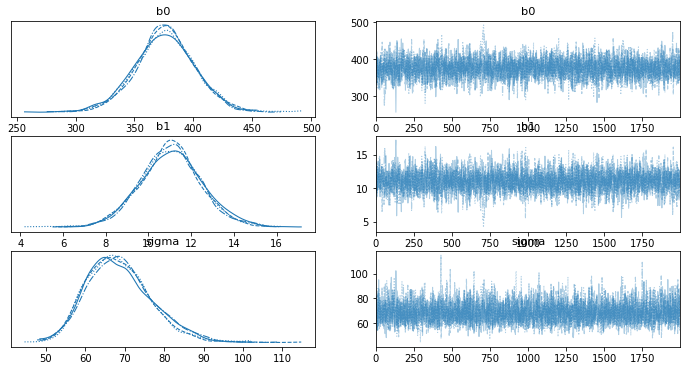

In [30]:
# MCMCの経過を簡易表示, muとsigmaのiter変化が見られる
arviz.plot_trace(fit)

#  Gelman-Rubin 統計量 (r_hat)、Highest density interval (HDI) などの簡易表示
summary = arviz.summary(fit)
summary

In [31]:
result3 = fit3.to_frame()

# 列名がややこしいので確認
print (result3.columns)

# 先頭を表示
result3.head()

Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
       'divergent__', 'energy__', 'b0', 'b1', 'b0_d.1', 'b0_d.2', 'b0_d.3',
       'b0_d.4', 'b1_d.1', 'b1_d.2', 'b1_d.3', 'b1_d.4', 'sigma_b0',
       'sigma_b1', 'sigma', 'b0_g.1', 'b0_g.2', 'b0_g.3', 'b0_g.4', 'b1_g.1',
       'b1_g.2', 'b1_g.3', 'b1_g.4'],
      dtype='object', name='parameters')


parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,b0,b1,b0_d.1,...,sigma_b1,sigma,b0_g.1,b0_g.2,b0_g.3,b0_g.4,b1_g.1,b1_g.2,b1_g.3,b1_g.4
draws,,,,,,,,,,,,,,,,,,,,,
0,-172.414068,0.963716,0.019108,5.0,63.0,0.0,181.262082,339.352867,18.488330,38.870219,...,8.822240,26.934311,378.223086,336.944434,312.828384,380.294443,8.569357,19.376458,12.733785,13.855107
1,-170.895639,0.951074,0.022282,7.0,191.0,0.0,183.503270,339.767469,22.671001,38.232147,...,16.682752,28.308591,377.999616,338.376308,363.108385,332.455851,8.083751,18.551245,9.663503,16.227732
2,-173.816183,0.975778,0.023738,7.0,191.0,0.0,182.106405,501.797521,2.664504,-135.030521,...,16.524450,25.922761,366.767000,347.501537,287.815271,623.599259,8.975016,19.156580,13.902551,4.618515
3,-172.625553,0.969824,0.021144,8.0,255.0,0.0,180.457537,317.155082,9.194679,41.605637,...,7.203644,26.168653,358.760719,315.519093,331.686091,569.872244,9.114250,21.470780,11.981290,6.654337
4,-174.625843,0.921531,0.019108,7.0,255.0,0.0,179.828443,473.816930,8.470074,-89.569893,...,5.386011,28.798528,384.247037,351.289031,308.929448,685.458572,7.505918,18.979220,12.518705,1.739431


In [32]:
b0_all, b1_all, sigma_all, sigma_b0, sigma_b1 = np.mean(fit3['b0']), np.mean(fit3['b1']), np.mean(fit3['sigma']), np.mean(fit3['sigma_b0']), np.mean(fit3['sigma_b1'])

b0_gg1, b1_gg1 = np.mean(result3['b0_g.1']), np.mean(result3['b1_g.1'])
print ("1", b0_gg1, b1_gg1)

b0_gg2, b1_gg2 = np.mean(result3['b0_g.2']), np.mean(result3['b1_g.2'])
print ("2", b0_gg2, b1_gg2)

b0_gg3, b1_gg3 = np.mean(result3['b0_g.3']), np.mean(result3['b1_g.3'])
print ("3", b0_gg3, b1_gg3)

b0_gg4, b1_gg4 = np.mean(result3['b0_g.4']), np.mean(result3['b1_g.4'])
print ("4", b0_gg4, b1_gg4)

sigma_b0_95 = np.quantile(result3['sigma_b0'],axis=0, q=[0.025,0.975]) # 回帰直線（平均値）の95%ベイズ信用区間を確認
print ("sigma_b0", sigma_b0, sigma_b0_95)

sigma_b1_95 = np.quantile(result3['sigma_b1'],axis=0, q=[0.025,0.975]) # 回帰直線（平均値）の95%ベイズ信用区間を確認
print ("sigma_b1", sigma_b1, sigma_b1_95)

sigma_95 = np.quantile(result3['sigma'],axis=0, q=[0.025,0.975]) # 回帰直線（平均値）の95%ベイズ信用区間を確認
print ("sigma", sigma_all, sigma_95)

1 382.71020202073805 7.77907346743214
2 335.3868399412994 19.35556199766375
3 325.4514091751467 11.913242144109356
4 474.3738009619175 10.067891381451984
sigma_b0 164.14080770418042 [  9.23775834 757.53963723]
sigma_b1 12.241059858217799 [ 3.11396827 46.072115  ]
sigma 28.642439494031976 [22.14715193 37.44190371]


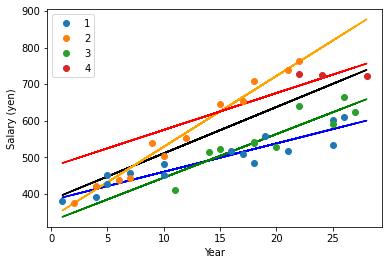

In [33]:
plt.plot(x, b0_all + b1_all * x, color='black')
plt.plot(x, b0_gg1 + b1_gg1 * x, color='blue')
plt.plot(x, b0_gg2 + b1_gg2 * x, color='orange')
plt.plot(x, b0_gg3 + b1_gg3 * x, color='green')
plt.plot(x, b0_gg4 + b1_gg4 * x, color='red')
plt.xlabel('Year') # 年齢、ただし実際の年齢から23を引いている。
plt.ylabel('Salary (yen)') # 年収

for name, group in groups: # これを使うと、特定の項目でグループ分けしたグラフが簡単に表示できます
    plt.plot(group.X, group.Y, marker='o', linestyle='', label=name)
plt.legend()

階層ベイズでは、b0_all と b1_all を使った全体の傾向に加えて、グループ別の回帰も作成できる。

sigma_b0より基本年収のグループによるばらつき(会社の差)は 162万もあること、sigma_b1 より昇給側のばらつきは、13万ほどで、ノイズはは 28万ほどとわかる。sigma_b0_95 をみると 95%信頼区間が大きすぎるかんじがするが、このあたりは、弱情報事前分布を活用することで改善できる。

上と下のグラフと比較すると、以前(下)は、グループ4の会社のデータの少なさより、年収が徐々に減少するという極端な回帰がとられていたのに対し、(上)では階層ベイズを導入したことで、大幅な傾向は増加傾向だということを考慮して、上昇する回帰に修正されている点が大きく違うことがわかる。

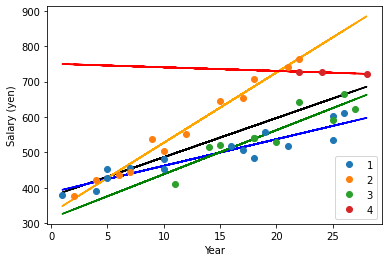

In [34]:
## 前の２タイプの線形回帰と比較するため、グラフを再度表示

# (1) の結果
plt.plot(x, b0 + b1 * x, color='black')

# (2) の結果
plt.plot(x, b0_g1 + b1_g1 * x, color='blue')
plt.plot(x, b0_g2 + b1_g2 * x, color='orange')
plt.plot(x, b0_g3 + b1_g3 * x, color='green')
plt.plot(x, b0_g4 + b1_g4 * x, color='red')
plt.xlabel('Year') # 年齢、ただし実際の年齢から23を引いている。
plt.ylabel('Salary (yen)') # 年収

for name, group in groups: # これを使うと、特定の項目でグループ分けしたグラフが簡単に表示できます
    plt.plot(group.X, group.Y, marker='o', linestyle='', label=name)
plt.legend()

## (4) 階層モデル v2


(3)のモデルの式は、以下のモデル式と等価になります。

$ 𝑦_{i} \sim 𝑁(𝑏_{0, \rm{group}} + 𝑏_{1, \rm{group}}𝑥_i, 𝜎)$<BR>
$ 𝑏_{0, \rm{group}} \sim 𝑁(b_0, \sigma_{b0})$<BR>
$ 𝑏_{1, \rm{group}} \sim 𝑁(b_1, \sigma_{b1})$<BR>
$(i = 1,2, ..., N, group = 1, 2, ... G)$

この場合、グループの切片は平均 $b_0$ の正規分布から、グループの傾きは、平均 $b_1$ の正規分布から生成された、と考える形になる。式としては等価ではあるが、ではあるが、Stanで計算した場合は、計算速度や収束に違いができる場合があるので注意が必要です。

In [35]:
# Stan に入力するデータを作成 (stan_data2と同じでよい)
stan_data4 = stan_data2


In [36]:
# stan_code3 との変更点は、transformed parameters がなくなりた点と、変更、とコメントした部分が変わっているだけです。かなりすっきりしていて、こちらのほうが実用的です。
stan_code4 = """
data { // stan_code2 より変更なし
  int N; // データ数
  int G; // グループ数
  real x[N];
  real y[N];
  int<lower=1, upper=G> group[N]; // グループIDデータ
}

parameters {
  real b0; // 全データに共通する切片(の平均)
  real b1; // 全データに共通する傾き(の平均)
  real b0_g[G]; // 変更：グループごとの切片(の平均)
  real b1_g[G]; // 変更：グループごとの傾き(の平均)
  real<lower=0> sigma_b0; // グループ差の切片の標準偏差
  real<lower=0> sigma_b1; // グループ差の傾きの標準偏差
  real<lower=0> sigma; // 全データに共通する標準偏差（ノイズ）
}

model {
  for (g in 1:G) {
    b0_g[g] ~ normal(b0, sigma_b0); // 変更：グループの切片は、平均 b0、標準偏差 sigma_b0 の正規分布を仮定する。
    b1_g[g] ~ normal(b1, sigma_b1); // 変更：グループの傾きは、平均 b1、標準偏差 sigma_b1 の正規分布を仮定する。
  }
  for (i in 1:N) {
    y[i] ~ normal (b0_g[group[i]] + b1_g[group[i]] * x[i], sigma); 
  }
}
"""

In [37]:
model4 = stan.build(stan_code4, data=stan_data4, random_seed=1)
# MCMCの実行
fit4 = model4.sample(
    num_warmup = 1000, # バーンイン期間
    num_chains = 4, #チェーン数
    num_samples= 2000, # 乱数生成の繰り返し回数
    num_thin = 1, #間引き数
)

Building...



Building: 31.1s, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   1% (101/12000)
Sampling:   2% (200/12000)
Sampling:   5% (600/12000)
Sampling:  11% (1300/12000)
Sampling:  32% (3800/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 4.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition wou

In [38]:
result4 = fit4.to_frame()

# 列名がややこしいので確認
print (result4.columns)
# 先頭を表示
result4.head()


Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
       'divergent__', 'energy__', 'b0', 'b1', 'b0_g.1', 'b0_g.2', 'b0_g.3',
       'b0_g.4', 'b1_g.1', 'b1_g.2', 'b1_g.3', 'b1_g.4', 'sigma_b0',
       'sigma_b1', 'sigma'],
      dtype='object', name='parameters')


parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,b0,b1,b0_g.1,b0_g.2,b0_g.3,b0_g.4,b1_g.1,b1_g.2,b1_g.3,b1_g.4,sigma_b0,sigma_b1,sigma
draws,,,,,,,,,,,,,,,,,,,,
0,-169.657559,0.776451,0.079318,6.0,63.0,0.0,179.878298,358.950967,9.399165,366.803229,353.943822,313.498579,410.273868,8.576299,17.982110,12.716816,11.571620,58.327953,4.882083,30.906607
1,-174.696909,0.999001,0.080971,6.0,63.0,0.0,178.854329,299.962861,14.114877,378.810238,309.933519,260.097725,437.620952,7.274795,21.191833,15.172102,11.719480,80.482876,28.475698,25.553567
2,-168.660717,0.993646,0.098514,5.0,31.0,0.0,175.009106,413.994109,17.902546,387.830640,331.911029,321.574967,512.012236,7.276359,19.657765,11.883975,8.724005,87.546205,6.034958,26.166658
3,-178.992431,0.981175,0.075091,6.0,63.0,0.0,186.133037,-42.421944,9.520147,354.895143,342.122792,378.698155,416.934501,9.258364,18.770681,9.832022,12.121337,725.043471,6.388500,25.977892
4,-169.446048,0.988108,0.079318,6.0,63.0,0.0,171.938372,381.434422,9.101891,389.659791,322.531872,353.521852,403.230615,7.339415,20.879822,10.966481,11.931425,40.242688,7.354458,25.242129


In [39]:
# 上でやった2タイプの線形回帰と変数がかぶらないよう、変えています
b0_all2, b1_all2, sigma_all2, sigma2_b0, sigma2_b1 = np.mean(result4['b0']), np.mean(result4['b1']), np.mean(result4['sigma']), np.mean(result4['sigma_b0']), np.mean(result4['sigma_b1'])

b0_ggg1, b1_ggg1 = np.mean(result4['b0_g.1']), np.mean(result4['b1_g.1'])
print ("1", b0_ggg1, b1_ggg1)

b0_ggg2, b1_ggg2 = np.mean(result4['b0_g.2']), np.mean(result4['b1_g.2'])
print ("2", b0_ggg2, b1_ggg2)

b0_ggg3, b1_ggg3 = np.mean(result4['b0_g.3']), np.mean(result4['b1_g.3'])
print ("3", b0_ggg3, b1_ggg3)

b0_ggg4, b1_ggg4 = np.mean(result4['b0_g.4']), np.mean(result4['b1_g.4'])
print ("4", b0_ggg4, b1_ggg4)

sigma2_b0_95 = np.quantile(result4['sigma_b0'],axis=0, q=[0.025,0.975]) # 回帰直線（平均値）の95%ベイズ信用区間を確認
print ("sigma_b0", sigma2_b0, sigma2_b0_95)

sigma2_b1_95 = np.quantile(result4['sigma_b1'],axis=0, q=[0.025,0.975]) # 回帰直線（平均値）の95%ベイズ信用区間を確認
print ("sigma_b1", sigma2_b1, sigma2_b1_95)

sigma2_95 = np.quantile(result4['sigma'],axis=0, q=[0.025,0.975]) # 回帰直線（平均値）の95%ベイズ信用区間を確認
print ("sigma", sigma_all2, sigma2_95)

1 383.71260603348355 7.728488511490379
2 334.73260657658557 19.410967406792455
3 323.8250523431679 11.993060844134565
4 483.7782133626017 9.701236173225489
sigma_b0 173.2189920671468 [ 12.63873256 797.87410439]
sigma_b1 11.893947130534668 [ 3.18847293 42.17719551]
sigma 28.499715293921202 [22.14580384 37.07132838]


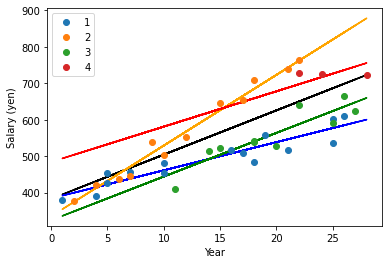

In [40]:
plt.plot(x, b0_all2 + b1_all2 * x, color='black')
plt.plot(x, b0_ggg1 + b1_ggg1 * x, color='blue')
plt.plot(x, b0_ggg2 + b1_ggg2 * x, color='orange')
plt.plot(x, b0_ggg3 + b1_ggg3 * x, color='green')
plt.plot(x, b0_ggg4 + b1_ggg4 * x, color='red')
plt.xlabel('Year') # 年齢、ただし実際の年齢から23を引いている。
plt.ylabel('Salary (yen)') # 年収

for name, group in groups: # これを使うと、特定の項目でグループ分けしたグラフが簡単に表示できます
    plt.plot(group.X, group.Y, marker='o', linestyle='', label=name)
plt.legend()

(3) と (4) のパラメータの数値の違いを確認しよう。
